# Router Workflow 테스트

router_workflow.py의 `process_chat` / `create_router_workflow`를 직접 사용해 테스트합니다.

## 0. 환경 설정

In [1]:
import os
import sys
from pathlib import Path

from dotenv import load_dotenv, find_dotenv

dotenv_path = find_dotenv()
print(f"Target .env path: {dotenv_path}")
loaded = load_dotenv(dotenv_path, override=True)
print(f"Loading successful: {loaded}")

project_root = str(Path(dotenv_path).parent)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root: {project_root}")

Target .env path: /Users/kimjunghyeon/Desktop/workspace/ai-agent/.env
Loading successful: True
Project root: /Users/kimjunghyeon/Desktop/workspace/ai-agent


## 1. 워크플로우 그래프 시각화

/Users/kimjunghyeon/Desktop/workspace/ai-agent/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kimjunghyeon/Desktop/workspace/ai-agent/.venv/lib/python3.13/site-packages/pyannote/audio/core/io.py:47: UserWarning: 
torchcodec is not installed correctly so built-in audio decoding will fail. Solutions are:
* use audio preloaded in-memory as a {'waveform': (channel, time) torch.Tensor, 'sample_rate': int} dictionary;
* fix torchcodec installation. Error message was:

Could not load libtorchcodec. Likely causes:
          1. FFmpeg is not properly installed in your environment. We support
             versions 4, 5, 6, 7, and 8, and we attempt to load libtorchcodec
             for each of those versions. Errors for versions not installed on
             your system are expected; only the error 

✅ Router Workflow 컴파일 완료


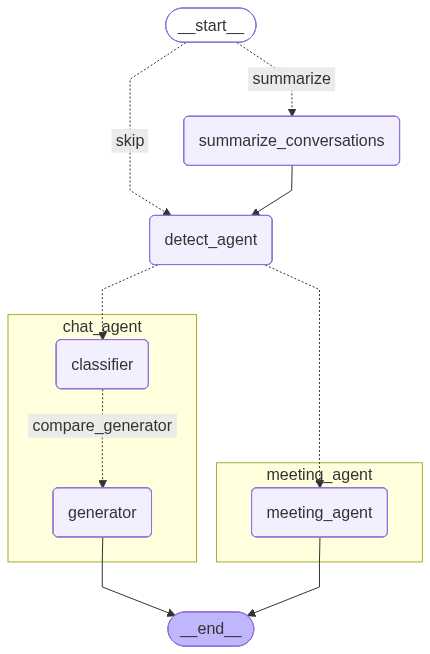

In [2]:
from IPython.display import Image

from app.agents.workflows.router_workflow import create_router_workflow

workflow, checkpointer_ctx = await create_router_workflow()

async with checkpointer_ctx as checkpointer:
    app = workflow.compile(checkpointer=checkpointer)
    print("✅ Router Workflow 컴파일 완료")
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## 2. detect_agent 단위 테스트

chat / meeting 분기 감지를 확인합니다.

In [3]:
from langchain_core.messages import HumanMessage

from app.agents.nodes.router.detect_agent import detect_agent

result = await detect_agent({
    "messages": [HumanMessage(content="LangGraph가 뭐야?")],
    "agent_type": None,
})
print(f"💬 Chat 감지: {result}")

💬 Chat 감지: {'agent_type': 'chat'}


In [4]:
result = await detect_agent({
    "messages": [HumanMessage(content="오늘 팀 회의 내용 회의록으로 정리해줘")],
    "agent_type": None,
})
print(f"🎙️ Meeting 감지: {result}")

🎙️ Meeting 감지: {'agent_type': 'meeting'}


## 3. token_router 단위 테스트

In [5]:
from app.agents.core.llm_provider import gpt4o
from app.agents.edges.router.token_router import route_check_token
from app.core.config import settings

state_few = {"messages": [HumanMessage(content="안녕")]}
print(f"짧은 메시지 토큰: {gpt4o.get_num_tokens_from_messages(state_few['messages'])} → {route_check_token(state_few)}")

# threshold(89,600)를 넘기려면 충분히 큰 반복 필요
long_content = "이것은 매우 긴 메시지입니다. " * 12000
state_many = {"messages": [HumanMessage(content=long_content)]}
print(f"긴 메시지 토큰  : {gpt4o.get_num_tokens_from_messages(state_many['messages'])} → {route_check_token(state_many)}")
print(f"threshold      : {settings.SUMMARIZE_MAX_TOKENS}")

짧은 메시지 토큰: 9 → skip
긴 메시지 토큰  : 96009 → summarize
threshold      : 89600


## 4. Chat Agent 전체 플로우 테스트

In [6]:
from app.agents.workflows.router_workflow import process_chat

result = await process_chat(
    message="LangGraph가 뭐야?",
    session_id="test-chat-1",
)

print(f"agent_type   : {result.get('agent_type')}")
print(f"question_type: {result.get('question_type')}")
print(f"model_used   : {result.get('model_used')}")
print(f"\nanswer:\n{result.get('answer')}")

Agent Router: agent_type = chat
Chat Router: question_type = FACT
agent_type   : None
question_type: FACT
model_used   : gpt-4o

answer:
죄송합니다. LangGraph에 대한 정보는 문서에서 확인할 수 없습니다.


## 5. Meeting Agent 전체 플로우 테스트

`audio_file_path`를 초기 state에 포함하여 실제 WhisperX STT + 회의록 생성까지 테스트합니다.

In [7]:
AUDIO_FILE = os.path.join(project_root, "data", "test", "유퀴즈.mp3")
print(f"오디오 파일: {AUDIO_FILE}")
print(f"파일 존재  : {os.path.exists(AUDIO_FILE)}")

오디오 파일: /Users/kimjunghyeon/Desktop/workspace/ai-agent/data/test/유퀴즈.mp3
파일 존재  : True


In [8]:
from app.infra.ai.whisperx_manager import whisperx_manager

print("WhisperX 모델 초기화 중... (처음 실행 시 시간이 걸립니다)")
await whisperx_manager.initialize()
print("✅ WhisperX 초기화 완료")

WhisperX 모델 초기화 중... (처음 실행 시 시간이 걸립니다)
2026-02-27 18:42:06 - whisperx.asr - INFO - No language specified, language will be detected for each audio file (increases inference time)
2026-02-27 18:42:06 - whisperx.vads.pyannote - INFO - Performing voice activity detection using Pyannote...


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.6.1. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint ../../.venv/lib/python3.13/site-packages/whisperx/assets/pytorch_model.bin`


2026-02-27 18:42:06 - whisperx.diarize - INFO - Loading diarization model: pyannote/speaker-diarization-community-1
✅ WhisperX 초기화 완료


In [9]:
result = await process_chat(
    message="회의록 작성해줘",
    session_id="test-meeting-1",
    agent_type="meeting",
    audio_file_path=AUDIO_FILE,
)

print(f"agent_type: {result.get('agent_type')}")
print(f"\n--- 회의록 ---")
print(result.get('answer'))

Agent Router: agent_type = meeting
2026-02-27 18:42:21 - whisperx.asr - INFO - Detected language: ko (1.00) in first 30s of audio


/Users/kimjunghyeon/Desktop/workspace/ai-agent/.venv/lib/python3.13/site-packages/pyannote/audio/models/blocks/pooling.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


agent_type: None

--- 회의록 ---
# 회의록

## 회의 개요
- 일시: 2023년 10월 14일
- 참석자: 2명 (Speaker 1, Speaker 2)
- 회의 주제: 유키즈 프로그램의 운세와 관상에 대한 논의

## 주요 논의 사항

### 1. 유키즈 프로그램의 운세
- Speaker 1은 유키즈 프로그램의 올해 운세에 대한 의견을 요청함.
- Speaker 2는 연애의 인연이 짧거나 없고, 일복이 많은 사람들이 많다는 의견을 제시함.
- Speaker 1은 이러한 의견에 충격을 받았으며, 자신도 일복이 많다는 이야기를 들었다고 언급함.

### 2. 관상과 운세의 관계
- Speaker 1은 잘생긴 사람들이 관상이 좋은지에 대해 질문함.
- Speaker 2는 잘생긴 것이 반드시 관상이 좋은 것은 아니며, 얼굴뿐만 아니라 사주, 풍수, 궁합 등이 운세에 영향을 미친다고 설명함.
- Speaker 2는 얼굴의 미학적 요소와 운세의 상호작용에 대해 언급하며, 유성 님의 경우 얼굴에 모자람이 있지만 운세는 얼굴뿐만 아니라 여러 요소가 연관되어 있다고 설명함.

## 결정 사항
1. 유키즈 프로그램의 운세에 대한 구체적인 결론은 도출되지 않음.
2. 관상과 운세의 관계에 대한 추가적인 논의 필요성 인지.

## 액션 아이템
1. [Speaker 1] - 유키즈 프로그램의 운세에 대한 추가 자료 조사 - [다음 회의 전]
2. [Speaker 2] - 관상과 운세의 관계에 대한 심층 분석 준비 - [다음 회의 전]

## 기타 사항
- 추가 논의가 필요한 사항: 관상과 운세의 관계에 대한 심층적인 이해 필요.
- 다음 회의 일정: 추후 조율 예정.


## 6. 멀티턴 대화 테스트 (checkpointer 확인)

In [10]:
session_id = "test-multiturn-1"

result1 = await process_chat(message="내 이름은 김철수야", session_id=session_id)
print(f"[1턴] answer: {result1.get('answer')}")

result2 = await process_chat(message="내 이름이 뭐라고 했지?", session_id=session_id)
print(f"[2턴] answer: {result2.get('answer')}")

Agent Router: agent_type = chat
Chat Router: question_type = FACT
[1턴] answer: 안녕하세요, 김철수님! 무엇을 도와드릴까요?
Agent Router: agent_type = chat
Chat Router: question_type = FACT
[2턴] answer: 당신의 이름은 김철수라고 말씀하셨습니다.
